# Bostrom Simulation
---

In [1]:
import math
import pandas as pd
from cadCAD.configuration.utils import config_sim
from cadCAD.configuration import Experiment
from cadCAD.engine import ExecutionContext
from cadCAD.engine import Executor
from cadCAD import configs

from utils.partial_state_update_blocks import partial_state_update_blocks
from utils.plots import prepare_df, boot_supply_plot, hydrogen_supply_plot, agents_count_plot, capitalization_plot, \
    gboot_price_plot, cyberlinks_per_day_plot, cyberlinks_count_plot, \
    ampere_supply_plot, ampere_mint_rate_plot, volt_supply_plot, volt_mint_rate_plot, \
    gpu_memory_usage_plot

## Initial state

In [2]:
sim_period = 10  # amount of years for simulating
timesteps_per_year = 365  # units per year (days)
agents_count_init = 750  # agents count in the genesis
capitalization_per_agent_init = 1  # initial capitalization per agent in ETH

initial_state = {
    'boot_inflation_rate': 0.05,  # initial inflation rate
    'boot_supply': 1_000_000_000_000_000,  # initial BOOT supply
    'boot_liquid_supply': 290_000_000_000_000,  # initial BOOT liquid supply
    'boot_frozen_supply': 700_000_000_000_000,  # initial BOOT frozen(on a gift contract) supply
    'boot_bonded_supply': 10_000_000_000_000,  # initial BOOT bonded supply
    'boot_claimed_supply': 0,  # initial BOOT claimed supply (from a gift contract)
    'boot_to_distribution_supply': 0,  # initial boot to distribution supply (transferred to gift claimer)
    'hydrogen_supply': 10_000_000_000_000,  # initial hydrogen supply (=initial boot bonded supply)
    'agents_count': agents_count_init,  # initial count of active agents
    'capitalization_per_agent': capitalization_per_agent_init,  # initial capitalization per agent in eth
    'capitalization_in_eth': agents_count_init * capitalization_per_agent_init,  # initial cap in eth
    'cyberlinks_per_day': 0,  # initial amount of cyberlinks per day
    'validator_revenue_gboot': 0,  # initial validator revenue in GBOOT
    'timestep_provision_boot': 0,  # initial timestep provision in GBOOT
    'gboot_price': agents_count_init * capitalization_per_agent_init / 1_000_000,  # 10^6 = Total supply 10^15 / Gboot 10^9
    'cyberlinks_count': 0,  # initial amount of cyberlinks
    'ampere_supply': 0,  # initial amount of AMPERE resource token
    'volt_supply': 0,  # initial amount of volt resource token
    'investmint_max_period': 365 * 3 // 2,  # initial max period of investminting in days
    'ampere_mint_rate': 1,  # initial rate if AMPERE minting rate
    'volt_mint_rate': 1,  # initial rate if VOLT minting rate
    'gpu_memory_usage': 0,  # initial gpu memory usage bytes
    'ampere_volt_ratio': 1,  # initial ration between ampere and volt
    'volt_liquid_supply': 0,  # initial VOLT liquid supply
    'ampere_liquid_supply': 0,  # initial AMPERE liquid supply
    'volt_minted_amount': 0,  # initial AMPERE minted amount
    'ampere_minted_amount': 0  # initial AMPERE minted amount
}

## Params for simulating

In [3]:
system_params = {
    # timesteps params
    'timesteps_per_year': [timesteps_per_year],  # units per year(days)
    
    # BOOT inflation params
    'boot_inflation_rate_change_annual': [0.20],  # maximum inflation rate change per year
    'boot_inflation_rate_min': [0.03],  # minimum percent of the inflation
    'boot_inflation_rate_max': [0.15],  # maximum percent of the inflation
    'boot_bonded_share_target': [0.90],  # desirable ratio between vested tokens and tokens supply
    'bonding_speed_coeff': [0.01], # the speed coefficient for tokens bonding
    
    # gift claim dynamics params
    'days_for_gift_activation': [30],
    'claimed_at_activation_share': [0.85], 
    'days_for_gift_full_claim': [150],
    'boot_gift_amount_init': [700_000_000_000_000],  # boots amount on a gift contract
    'liquid_boot_supply_share': [0.10],  # desirable liquid BOOT supply share
    
    # understanding network effects params
    'agents_count_at_activation': [100_000],  # amount of agents to gift release
    'start_capitalization_per_agent': [1],  # initial capitalization per agent eth
    
    # predicting VOLT demand params
    'cyberlinks_transactions_coeff': [15],  # speed coefficient of cyberlinks txs growing
    'extra_links': [0],  # extra links txs amount
    'guaranteed_links': [0],  # guaranteed links txs amount
    
    # AMPERE and VOLT minting params
    'ampere_base_halving_period': [365 * 3 // 2],  # period of mint rate halving for AMPERE mint rate
    'volt_base_halving_period': [365 * 3 // 2],  # period of mint rate halving for VOLT mint rate
    'ampere_mint_rate_init': [1],  # initial mint rate for AMPERE
    'volt_mint_rate_init': [1],  # initial mint rate for VOLT
    'ampere_base_investmint_amount': [100_000_000],  # initial cost for resource token in 1 cycle
    'volt_base_investmint_amount': [1_000_000_000],  # initial cost for resource token in 1 cycle
    'ampere_base_investmint_period': [30],  # base investmint period for AMPERE days
    'volt_base_investmint_period': [30],  # base investmint period for VOLT days
    'investmint_max_period_init': [365 * 3 // 2],  # initial value for investmint maximum period
    'horizont_period_init': [365 * 3 // 2],  # period for max investmint period doubling days
    
    # investments into infrastructure params
    'validator_commission': [0.1],  #average validator comission
    'max_validator_count': [92], # max amount of validators
    
    # particles util
    'particle_per_cyberlink': [0.1]  # amount of particle per cyberlink
}

## Context Preparation

In [4]:
del configs[:]
experiment = Experiment()

sim_config = config_sim({
    'N': 1,
    'T': range(int(math.ceil(sim_period * timesteps_per_year))),
    'M': system_params
})

experiment.append_configs(
    initial_state = initial_state,
    partial_state_update_blocks = partial_state_update_blocks,
    sim_configs = sim_config
)

## Simulation

In [5]:
exec_context = ExecutionContext()

simulation = Executor(exec_context=exec_context, configs=configs)
raw_result, tensor_field, sessions = simulation.execute()
simulation_result_df = pd.DataFrame(raw_result)
simulation_result_df = prepare_df(simulation_result_df)


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (3650, 29, 1, 27)
Execution Method: local_simulations
SimIDs   : [0]
SubsetIDs: [0]
Ns       : [0]
ExpIDs   : [0]
Execution Mode: single_threaded
Total execution time: 0.29s


## Simulation Results
### BOOT and H Supply

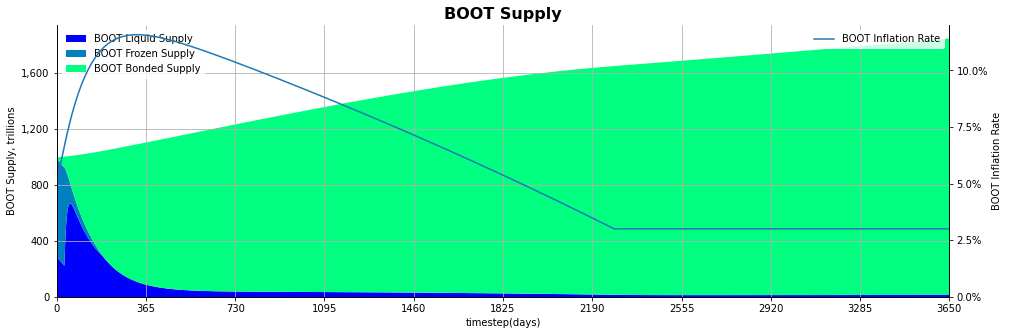

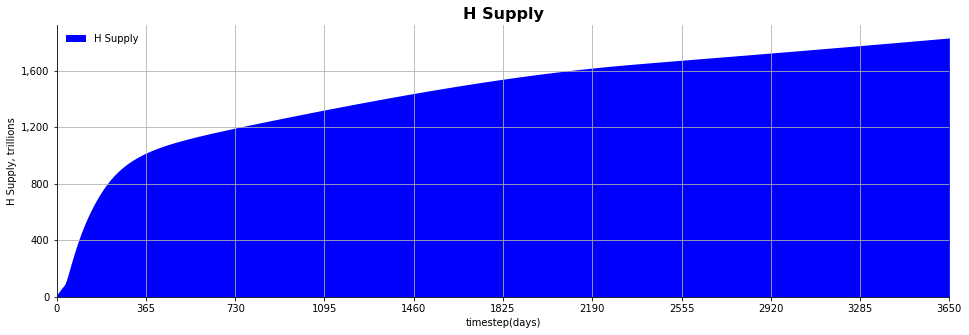

In [6]:
boot_supply_plot(simulation_result_df)
hydrogen_supply_plot(simulation_result_df)

### BOOT Capitalization

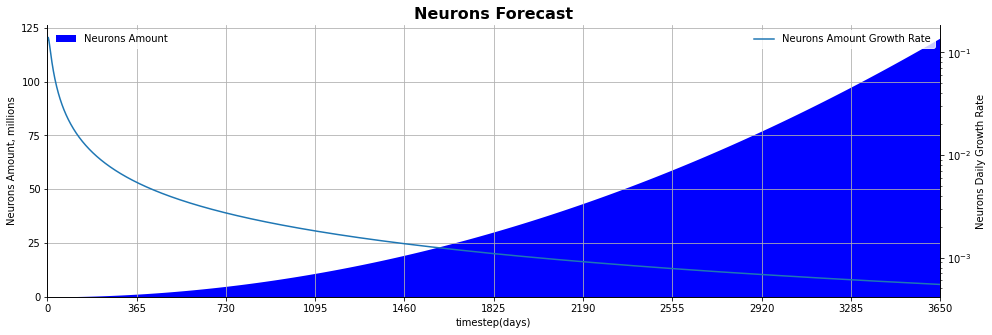

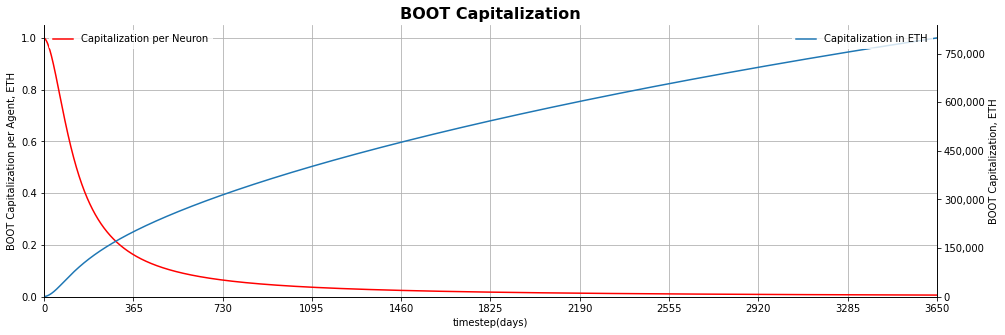

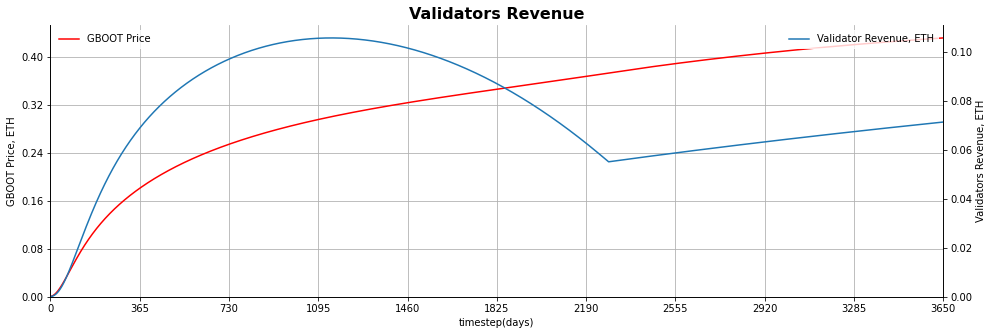

In [7]:
agents_count_plot(simulation_result_df)
capitalization_plot(simulation_result_df)
gboot_price_plot(simulation_result_df)

### cyberLinks

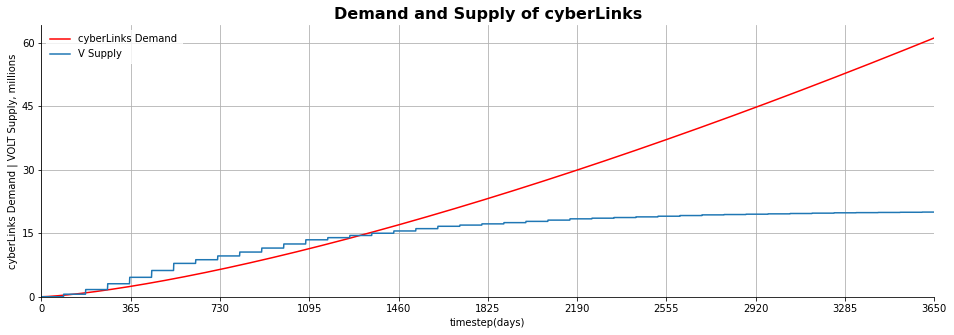

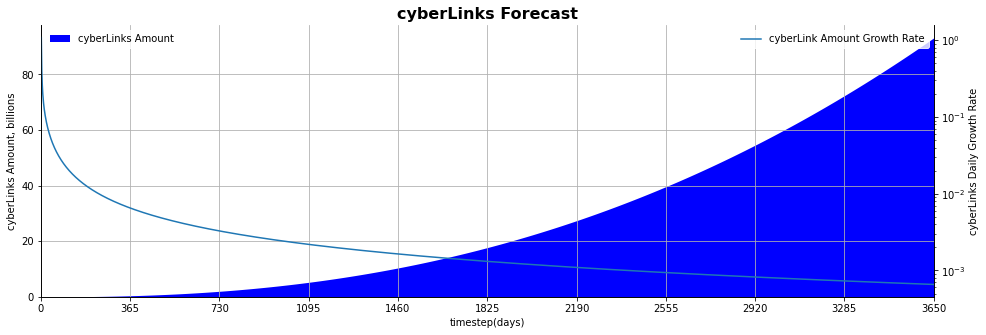

In [8]:
cyberlinks_per_day_plot(simulation_result_df)
cyberlinks_count_plot(simulation_result_df)

### V Supply

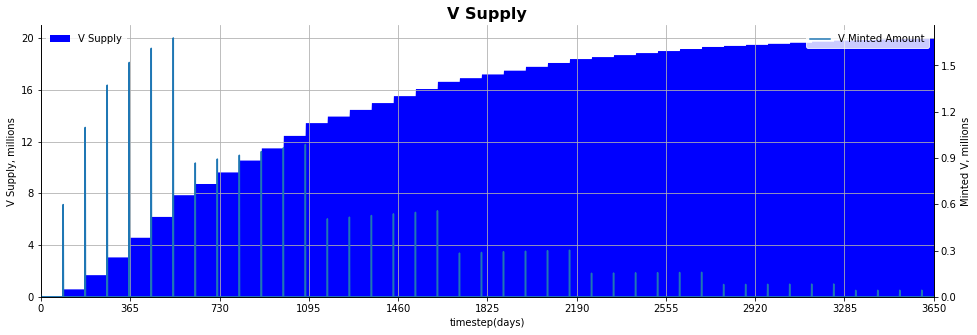

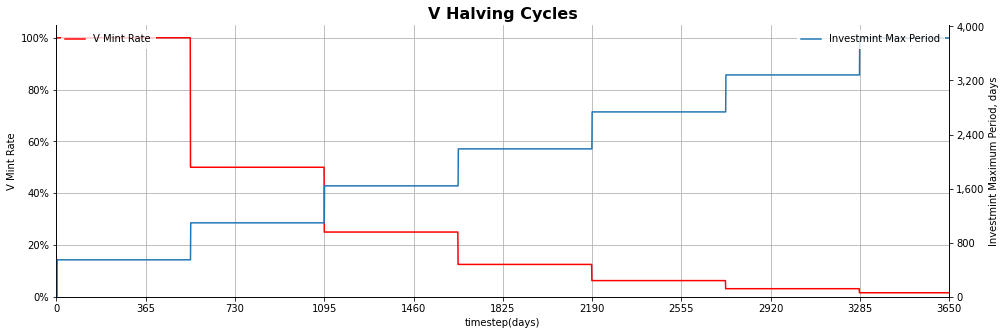

In [9]:
volt_supply_plot(simulation_result_df)
volt_mint_rate_plot(simulation_result_df)

### A Supply

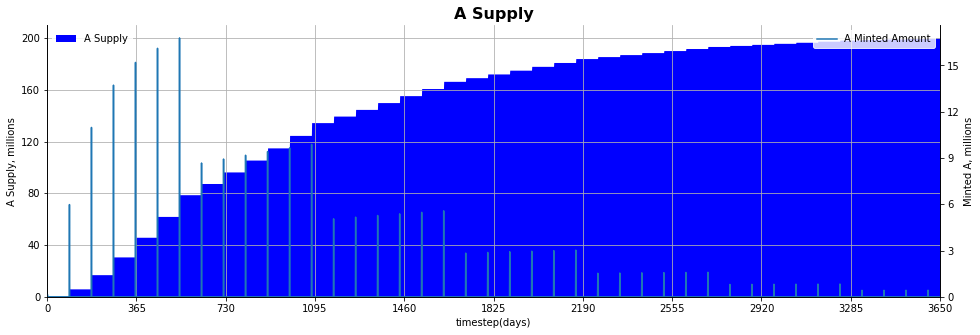

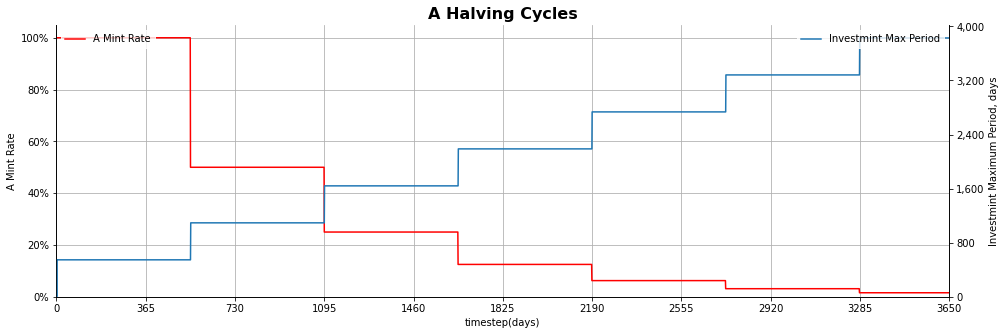

In [10]:
ampere_supply_plot(simulation_result_df)
ampere_mint_rate_plot(simulation_result_df)

### GPU Usage

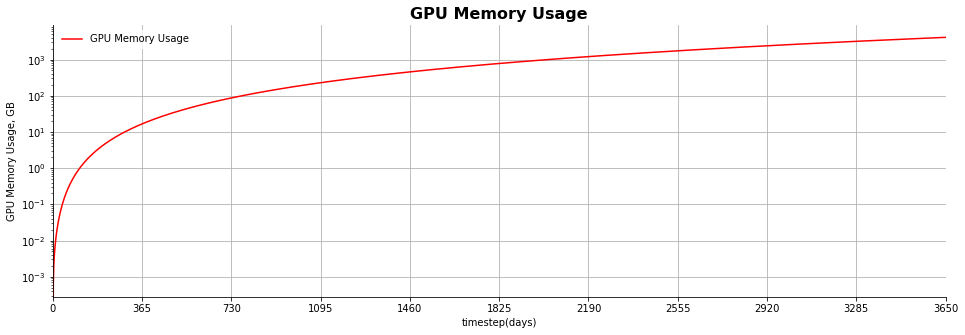

In [11]:
gpu_memory_usage_plot(simulation_result_df)